# XGBoost Notebook - Heading Matching

The purpose of this notebook is to use the results from the heading matching scheme and predict the slope of road links.


In [1]:
# Imports
        
import os
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from datetime import datetime


# Constants
DATA_DIR = "probe_data_map_matching"

link_headers = ["linkPVID", 
                "refNodeID", 
                "nrefNodeID", 
                "length", 
                "functionalClass", 
                "directionOfTravel", 
                "speedCategory", 
                "fromRefSpeedLimit", 
                "toRefSpeedLimit", 
                "fromRefNumLanes", 
                "toRefNumLanes", 
                "multiDigitized", 
                "urban", 
                "timeZone", 
                "shapeInfo", 
                "curvatureInfo", 
                "slopeInfo"]

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read in the Link Data
link_data = pd.read_csv(os.path.join(DATA_DIR, "Partition6467LinkData.csv"), header=None, names=link_headers)
link_data.drop('curvatureInfo', axis=1, inplace=True)

print(link_data.shape)

link_data.head()

(200089, 16)


,linkPVID,refNodeID,nrefNodeID,length,functionalClass,directionOfTravel,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,slopeInfo
0,62007637,162844982,162809070,335.04,5,B,7,30,30,0,0,F,T,0.0,51.4965800/9.3862299/|51.4994700/9.3848799/,NaN
1,567329767,162844982,162981512,134.56,5,B,7,0,0,0,0,F,T,0.0,51.4965800/9.3862299/|51.4966899/9.3867100/|51...,NaN
2,62007648,162877732,162844982,97.01,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4965800/9.3862299/,NaN
3,78670326,162877732,163152693,314.84,5,B,7,30,30,0,0,F,T,0.0,51.4962899/9.3849100/|51.4990000/9.3836099/,NaN
4,51881672,174713859,174587951,110.17,3,B,6,50,50,2,2,F,T,0.0,53.0643099/8.7903400/45.79|53.0650299/8.791470...,0.00/-0.090|110.17/0.062


In [3]:
# how many have slope info?
link_data.dropna().shape

(53517, 16)

In [4]:
# Actually get rid of the missings
link_data.dropna(inplace=True)

In [6]:
# Read in the (Matched) Probe Data

probe_data = pd.read_csv(os.path.join(DATA_DIR, "heading_match.csv"))
probe_data['dateTime'] = pd.to_datetime(probe_data['dateTime'], format='%Y-%m-%d %H:%M:%S')
#probe_data.to_pickle(os.path.join(DATA_DIR, 'converted_simple_match.pickle'))

#probe_data = pd.read_pickle(os.path.join(DATA_DIR, 'converted_probe_linked_data.pickle'))

## Quick Analysis of Simple Matching Results

Here we take a quick look to see what kind of coverage we have from the simple matching scheme. Do we match to most of the links? Very few? 

In [7]:
probe_data.shape

(3278652, 12)

In [8]:
# How many unique linkPVID's are contained in the matched probe data
print("Roughly what do the Groups look like?")
itr = 0
for i in probe_data.groupby('linkPVID').groups:
    if itr <= 5:
        print(i, probe_data.groupby('linkPVID').groups[i])
        itr += 1

print("There are {} Unique linkPVID's represented".format(len(probe_data.groupby('linkPVID').groups)))

Roughly what do the Groups look like?
-1 Int64Index([   6515,   15463,   21059,   21060,   24723,   24724,   24725,
              24726,   24727,   24728,
            ...
            3263400, 3263401, 3263402, 3263403, 3264645, 3265103, 3265104,
            3265105, 3271241, 3277304],
           dtype='int64', length=1159)
0 Int64Index([0], dtype='int64')
51514446 Int64Index([1112173, 1112174, 1112175, 1112898, 1911469, 1911470, 1911473,
            1911474, 1911475, 1911476, 2060557, 2368809, 2368810, 2368811,
            2368812, 2579196, 2579197],
           dtype='int64')
51514498 Int64Index([1750453, 1750454, 1750455], dtype='int64')
51514539 Int64Index([2362848, 2362849, 2362850], dtype='int64')
51514549 Int64Index([1913646, 1913647, 1913648, 2142217, 2142218, 2245818], dtype='int64')
There are 189623 Unique linkPVID's represented


So, 189621 Unique PVID's are covered. Given that there are roughly 200,000 links in the dataset, this level of coverage is actually quite good.

### Join to Link Data

In [9]:
joined_data = probe_data.join(link_data.set_index('linkPVID'), on='linkPVID', how='inner', lsuffix='l', rsuffix='r')


In [10]:
joined_data.head()

,sampleID,dateTime,latitude,longitude,altitude,heading,sourceCode,speed,directionOfTravell,distFromLink,...,speedCategory,fromRefSpeedLimit,toRefSpeedLimit,fromRefNumLanes,toRefNumLanes,multiDigitized,urban,timeZone,shapeInfo,slopeInfo
63,4552,2009-06-13 11:47:18,53.064978,8.791656,42,44,13,23,B,12.953742,...,7,50,50,2,2,F,T,0.0,53.0650299/8.7914700/45.74|53.0657462/8.792644...,0.00/0.062|111.93/0.170|212.54/0.081
64,4552,2009-06-13 11:47:23,53.065243,8.792106,42,45,13,31,B,13.642382,...,7,50,50,2,2,F,T,0.0,53.0650299/8.7914700/45.74|53.0657462/8.792644...,0.00/0.062|111.93/0.170|212.54/0.081
65,4552,2009-06-13 11:47:28,53.065549,8.792615,42,44,13,40,B,13.980992,...,7,50,50,2,2,F,T,0.0,53.0650299/8.7914700/45.74|53.0657462/8.792644...,0.00/0.062|111.93/0.170|212.54/0.081
106749,152772,2009-07-13 12:13:02,53.065634,8.792478,57,227,13,49,B,0.823425,...,7,50,50,2,2,F,T,0.0,53.0650299/8.7914700/45.74|53.0657462/8.792644...,0.00/0.062|111.93/0.170|212.54/0.081
106750,152772,2009-07-13 12:13:08,53.065110,8.791617,57,226,13,49,B,0.750220,...,7,50,50,2,2,F,T,0.0,53.0650299/8.7914700/45.74|53.0657462/8.792644...,0.00/0.062|111.93/0.170|212.54/0.081


In [11]:
print("And now after the join and NA removal, we have {} rows of data".format(joined_data.shape[0]))

And now after the join and NA removal, we have 1613716 rows of data


## Model Setup

Here we want to build an ML Model to predict the slope of a link given some gps probe data. In order to do that we'll use the average slope of the link as the target and (a subset) of the rest of the columns of data as features for the model to predict it.

We opt to use XGBoost for a couple reasons:

First, it is a tree-based model which we think is well-suited to the lat/lon features. While we are doing a _regression_ model, we do not believe that a linear regression is the best tool for it since latitude and longitude, while real-valued, are not truly ordinal features well-suited to linear (OLS) modeling. On the other hand, tree-based (in particular boosted tree-based) models allow us to learn a complex topographical map over these features because of different split points.

Second, it is stable, well-developed and highly parallelizable which is allows us to scale to large datasets. This is appropriate because we have 3.3 million probe points.

Finally, XGBoost is a favorite among Data Scientists and Kaggle Competition winners due to its often first-class performance without requiring as much data, maintenance, or computing resources as neural networks. And, since we are not interested in automatic feature extraction such as one might attempt with Deep Learning, we think that XGBoost is a good fit.

## Feature Engineering

However, that doesn't mean that we aren't interested in creating new features. We think that there could be a lot of value in features that take the sequence of probe points (the trajectory) into account. These rollup features are things like distance traveled since last point, change in speed, change in elevation, sliding window estimates of slope, etc.

They are computed below.

In [12]:
def rolling_diff(df):
    return df[-1] - df[0]

cleaned_joined_data = joined_data.dropna()

cleaned_joined_data['avg_link_slope'] = cleaned_joined_data['slopeInfo'].apply(lambda x: np.mean([float(i.split('/')[1]) for i in x.split('|')]))

gdf = cleaned_joined_data.groupby('sampleID')
cleaned_joined_data['delta_elevation'] = gdf['altitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_latitude'] = gdf['latitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_longitude'] = gdf['longitude'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['delta_speed'] = gdf['speed'].apply(lambda x: x.rolling(2, min_periods=2).apply(rolling_diff)).reset_index(0, drop=True)
cleaned_joined_data['rolling_slope'] = cleaned_joined_data['delta_elevation'] / np.sqrt(cleaned_joined_data['delta_latitude'] ** 2 + cleaned_joined_data['delta_longitude'] ** 2)
cleaned_joined_data['rolling_acc'] = cleaned_joined_data['delta_speed'] / np.sqrt(cleaned_joined_data['delta_latitude'] ** 2 + cleaned_joined_data['delta_longitude'] ** 2)

cleaned_joined_data = cleaned_joined_data.dropna()


In [35]:

cleaned_joined_data['speed_limit_diff'] = cleaned_joined_data['speed'] - cleaned_joined_data['fromRefSpeedLimit']

cleaned_joined_data['multiDigitized'] = cleaned_joined_data['multiDigitized'].apply(lambda x: 1 if x in 'T' else 0)



/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
feature_set = [#'sampleID',
                   #'dateTime',
                   'altitude',
                    'latitude', 
                    'longitude',
                   'speed', 
                   'heading', 
                   'length',
                   #'functionalClass',
                   #'fromRefSpeedLimit',
                    'speed_limit_diff',
                   #'toRefSpeedLimit', 
                   #'fromRefNumLanes', 
                   #'toRefNumLanes',
                    #'multiDigitized',
                    #'delta_elevation',
                    'distFromLink',
                    'delta_speed',
                    'rolling_acc',
                    'rolling_slope',
                   'avg_link_slope']

subset = cleaned_joined_data[feature_set]

print(subset.shape)
import sklearn
train, test = sklearn.cross_validation.train_test_split(subset, test_size = 0.2, random_state=1)


dtrain = xgb.DMatrix(train.values[:,:-1], train.values[:,-1], feature_names = feature_set[:-1])
dtest = xgb.DMatrix(test.values[:,:-1], test.values[:,-1], feature_names = feature_set[:-1])
param = {'max_depth':10, 'eta':0.2, 'silent':1, "lambda": 1.2, "objective": "reg:linear", "booster":"gbtree" }
param['nthread'] = 63
param['eval_metric'] = 'rmse'
evallist  = [(dtest,'eval'), (dtrain,'train')]
num_round = 2200
bst = xgb.train( param, dtrain, num_round, evallist, early_stopping_rounds=10)


(773683, 12)
[0]	eval-rmse:1.01641	train-rmse:1.01828
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:0.957946	train-rmse:0.95913
[2]	eval-rmse:0.90562	train-rmse:0.906114
[3]	eval-rmse:0.876948	train-rmse:0.877182
[4]	eval-rmse:0.840648	train-rmse:0.84013
[5]	eval-rmse:0.820613	train-rmse:0.819274
[6]	eval-rmse:0.80394	train-rmse:0.802082
[7]	eval-rmse:0.78299	train-rmse:0.779289
[8]	eval-rmse:0.767983	train-rmse:0.764081
[9]	eval-rmse:0.753821	train-rmse:0.748952
[10]	eval-rmse:0.744419	train-rmse:0.739392
[11]	eval-rmse:0.734305	train-rmse:0.728468
[12]	eval-rmse:0.729704	train-rmse:0.723782
[13]	eval-rmse:0.725681	train-rmse:0.719502
[14]	eval-rmse:0.705848	train-rmse:0.699188
[15]	eval-rmse:0.692846	train-rmse:0.685128
[16]	eval-rmse:0.677208	train-rmse:0.66858
[17]	eval-rmse:0.675184	train-rmse:0.666472
[18]	eval-rmse:0.667112	train-rmse:0.657452
[19]	eval-rmse:0.662974	

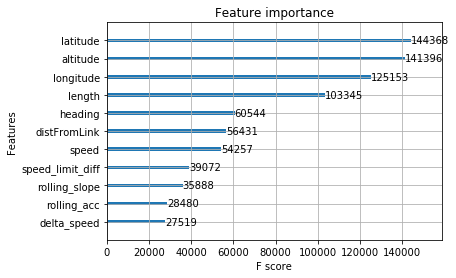

In [61]:
xgb.plot_importance(bst)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


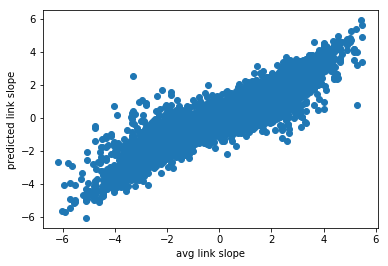

In [62]:
preds = bst.predict(dtest)
zipped_preds = test
zipped_preds['preds'] = preds

plt.figure()
plt.scatter(zipped_preds['avg_link_slope'], zipped_preds['preds'])
plt.xlabel('avg link slope')
plt.ylabel('predicted link slope')
plt.show()